In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import spotpy
from scipy import stats

import cartopy.feature as cfeature
import numpy as np
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot as pplt


#warning
import warnings
warnings.filterwarnings('ignore')

dir_in = 'D:/Xanthos-Repo/Data for Figures-Xanthos WM'

In [2]:
#############################################################
# Xanthos grid info
basinName = pd.read_csv(dir_in + '/BasinNames235.txt')
basin_id = pd.read_csv(dir_in + '/basin.csv')
#GRDC list
GRDC_xanthosCoordIndx = pd.read_csv(dir_in + '/GRDC_stations_list.csv')
#GRDC data
grdc_basin_m3persec  =  pd.read_csv(dir_in + '/grdc_91basin_m3persec_1971_1990_monthly.csv')
##
nbasins = GRDC_xanthosCoordIndx.shape[0]
basins91 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_91 = [basinName['Basin_Name'][basins91[ii] - 1] for ii in range(nbasins)]

## flow data
grdc_m3persec = np.zeros([nbasins, 240])
for ii in range(nbasins):   
    basin_num = basins91[ii]
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    grdc_m3persec[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])


## KGE : Calibration & Validation

In [3]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    import numpy as np
    from datetime import date, timedelta
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')

    return data_ts

In [4]:
file_dir_watch_vald = dir_in + '/Simulated/SimulatedFinal-HP/flow/'
file_dir_watch_natr = dir_in + '/Simulated/SimulatedFinal-YL/flow/'
basin_235_xanthos = gpd.read_file(dir_in + '/basin_235_xanthos/basin_harmed.shp')

xx = np.zeros([nbasins,])
for ii in range(nbasins):
    basin_num = basins91[ii]    
    ## observed
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    grdc_m3persec = np.array(grdc_basin_m3persec[aa]['q'])
    qobs_calibration= grdc_m3persec[0:120]
    qobs_validation = grdc_m3persec[120:240]    
    ## simulated
    data_basin = np.load(file_dir_watch_vald + 'SimFlow_' + str(basin_num) + '.npy')   
    qsim_calibration= data_basin[0:120]
    qsim_validation = data_basin[120:240]
    ## Natural
    data_basin_yl = np.load(file_dir_watch_natr + 'SimFlow_' + str(basin_num) + '.npy')   
    qsim_calibration_yl= data_basin_yl[0:120]
    qsim_validation_yl = data_basin_yl[120:240]
    qsim_calibration_tsyl = timeseries_coverter(qsim_calibration_yl, start_yr=1971, ending_yr=1980)
    #xx[ii] = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration) - spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration_yl) 



    #################
    indx_poly = np.where(basin_235_xanthos['GRIDCODE']==basin_num)[0]
    basin_235_xanthos.loc[indx_poly,'Natural'] = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration_yl) 
    basin_235_xanthos.loc[indx_poly,'Regulated'] = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration)  
    basin_235_xanthos.loc[indx_poly,'Difference'] = spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration) - spotpy.objectivefunctions.kge(qobs_calibration, qsim_calibration_yl) 

### Mapping

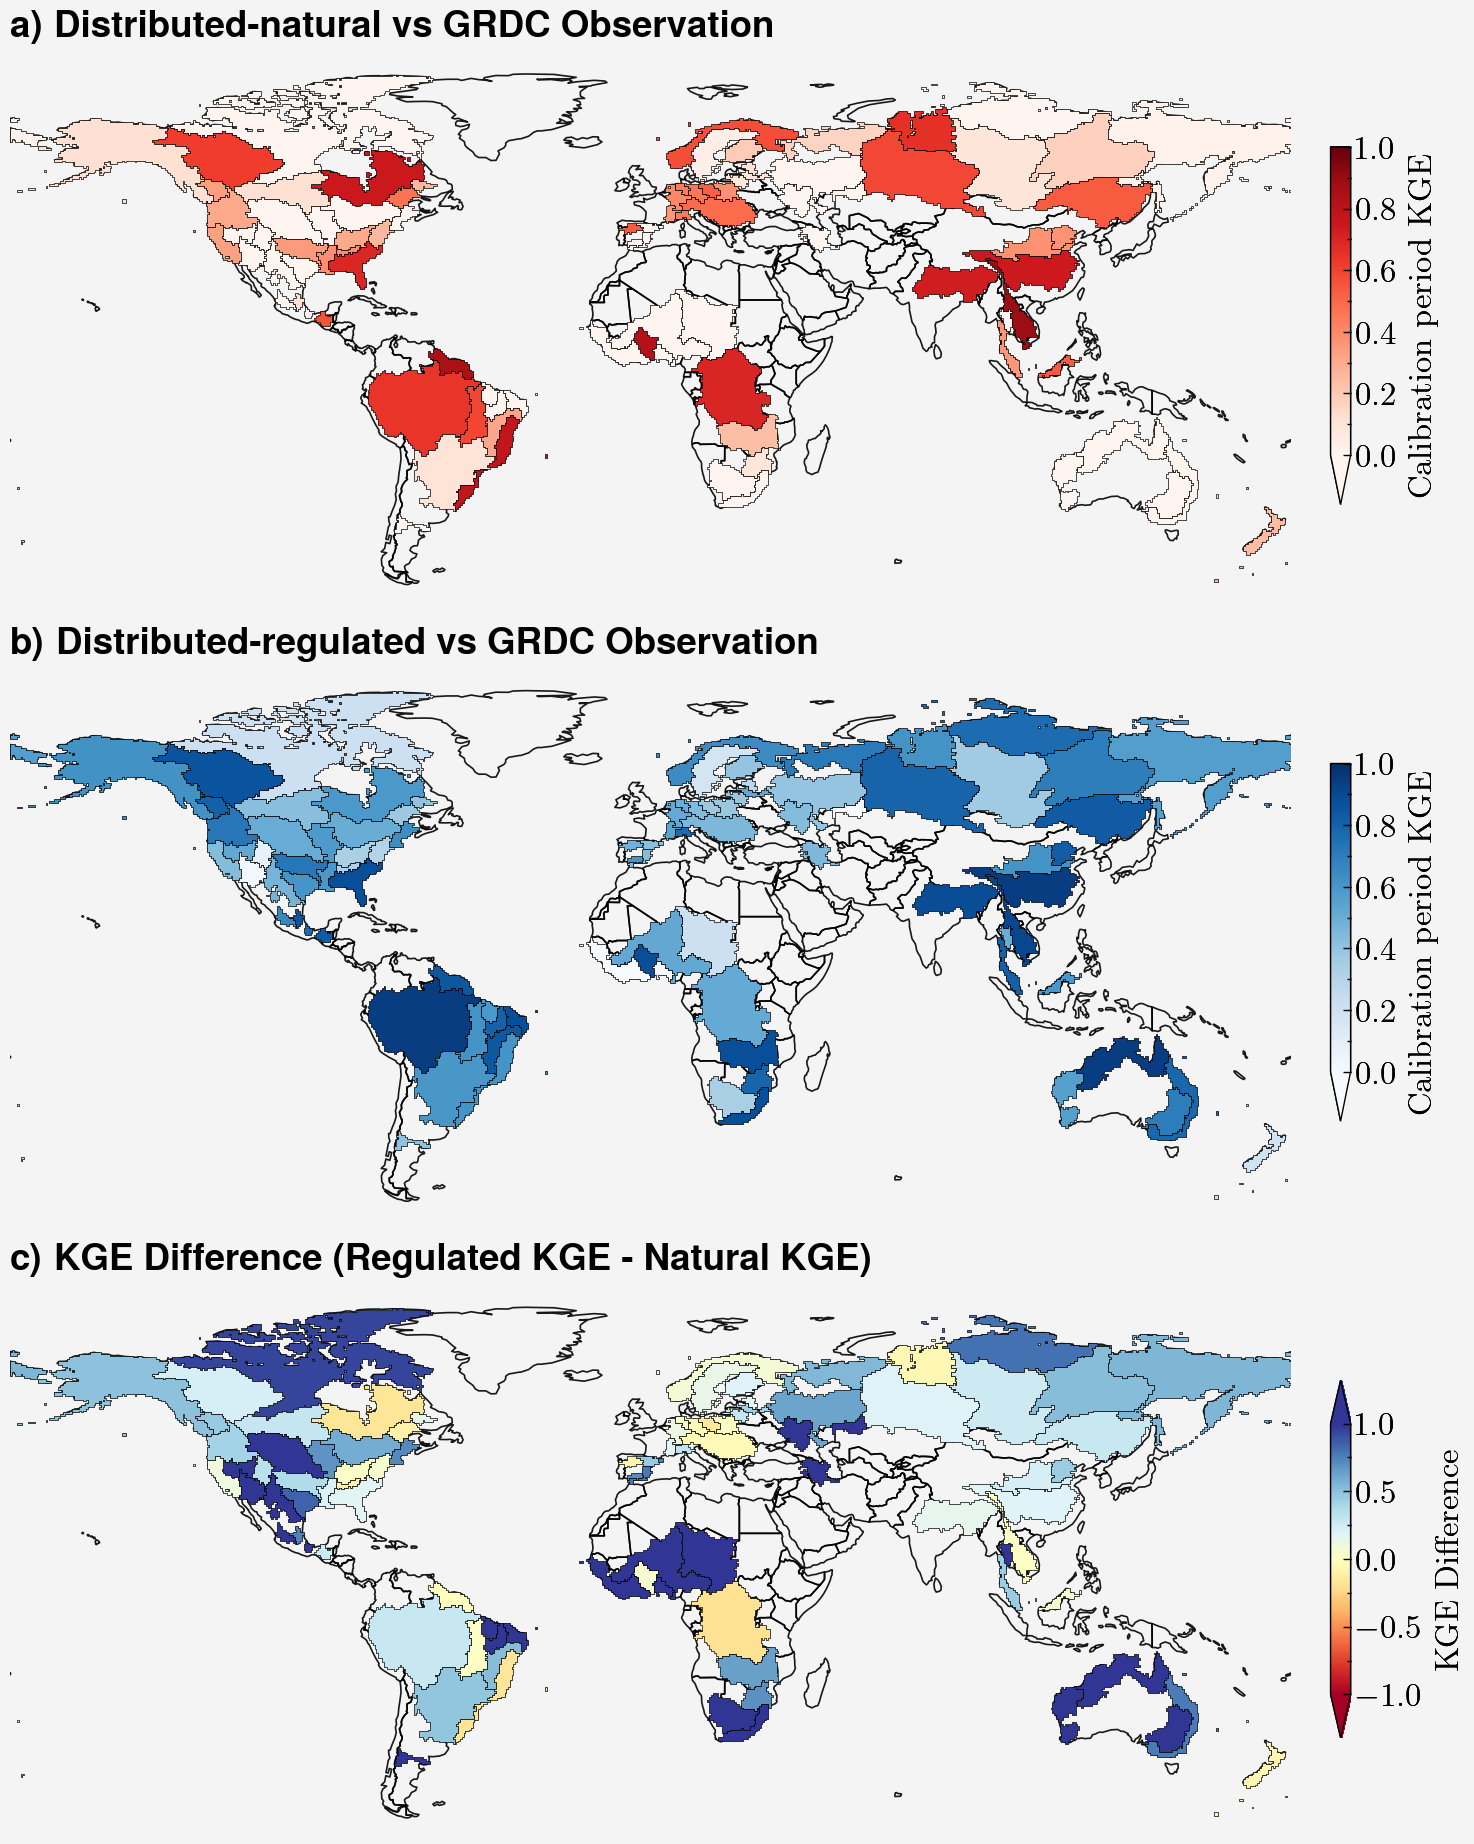

In [5]:
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12, 'font.weight':'bold'}) 
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'

SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
BASE_PLOT = {"facecolor": 'none', "edgecolor": 'k', "alpha": 0.9,}

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
global_shape = gpd.GeoDataFrame(geometry=world.geometry, crs=world.crs)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
CRS = "EPSG:4326"

## Ploting
fig, axes = pplt.subplots(nrows=3, ncols=1, share=0, space = 2, refheight='2.75')
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
        # Calibration
        ax = axes[0]
        #global_shape.to_crs(CRS).plot(ax=ax,**BASE_PLOT) 
        world.to_crs(CRS).plot(ax=ax,**BASE_PLOT)    
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='Natural',  cmap='reds', legend=True, edgecolor='k',linewidth=0.25, vmin=0, vmax=1.0,
                                        legend_kwds={'label': "Calibration period KGE", 'shrink':0.65,'width':0.10,
                                                     'extend':'min', 'ticks':0.2, 'minorticks':0.1, 'labelweight':'bold', 'labelsize':12})                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90]) 
        ax.format(title='Distributed-natural vs GRDC Observation', titleweight = 'bold', titleloc='l',abcstyle='a)', fontsize=12)

        # Validation   
        ax = axes[1]
        #global_shape.to_crs(CRS).plot(ax=ax,**BASE_PLOT)    
        world.to_crs(CRS).plot(ax=ax,**BASE_PLOT)  
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='Regulated', cmap='blues', legend=True,  edgecolor='k',linewidth=0.25, vmin=0, vmax=1.0,
                                        legend_kwds={'label': "Calibration period KGE", 'shrink':0.65,'width':0.10,
                                                     'extend':'min', 'ticks':0.2, 'minorticks':0.1, 'labelweight':'bold', 'labelsize':12})                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90])    
        ax.format(title='Distributed-regulated vs GRDC Observation', titleweight = 'bold', titleloc='l',abcstyle='a)', fontsize=12)
          

        # Difference   
        ax = axes[2]
        #global_shape.to_crs(CRS).plot(ax=ax,**BASE_PLOT)    
        world.to_crs(CRS).plot(ax=ax,**BASE_PLOT)  
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='Difference', cmap='RdYlBu', legend=True,  edgecolor='k',linewidth=0.25, vmin=-1, vmax=1.0, 
                                        legend_kwds={'label': "KGE Difference", 'shrink':0.65,'width':0.10,
                                                     'extend':'both', 'ticks':0.5, 'minorticks':0.25, 'labelweight':'bold', 'labelsize':12})                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90])    
        ax.format(abc=True , title='KGE Difference (Regulated KGE - Natural KGE)', titleweight = 'bold', titleloc='l',abcstyle='a)', fontsize=12)
plt.tight_layout()


#dir_out = 'D:\\Xanthos-Repo\\figures\\'
#plt.savefig("dir_out + Figure-9.png", **SAVE_KWDS)   